# Denoising and deblurring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# from tqdm import tqdm

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

In this chapter we will apply the things we learned about filtering to denoising and deblurring. We will take a statistical perspective. The resulting algorithms will thus be an application of linear regression to these important problems. We will explore properties and limitations of linear algorithms.

## Denoising

```{table} Notation.
:name: notation-table

| Objects | Notation |
|---|---|
| Deterministic scalars | $x$, $y$, $\alpha$|
| Random scalars | $\rx$, $\ry$ |
| Deterministic vectors | $\vx$, $\vy$ |
| Random vectors | $\rvx$, $\rvy$ |
| Deterministic matrices | $\mA$, $\mB$ |
| Random matrices | $\rmA$, $\rmB$ |
```

Image denoising is a fundamental image restoration method. Even though it is an old problem, there is a steady stream of creative new approaches, in particular based on deep learning. Denoising is also a basic building block in more complicated systems, for example diffusion–based generative models for images. NB: you could show this? Next year?
Denoising algorithms are used in digital cameras in low light conditions. 

Let's first load an image and add noise to it.

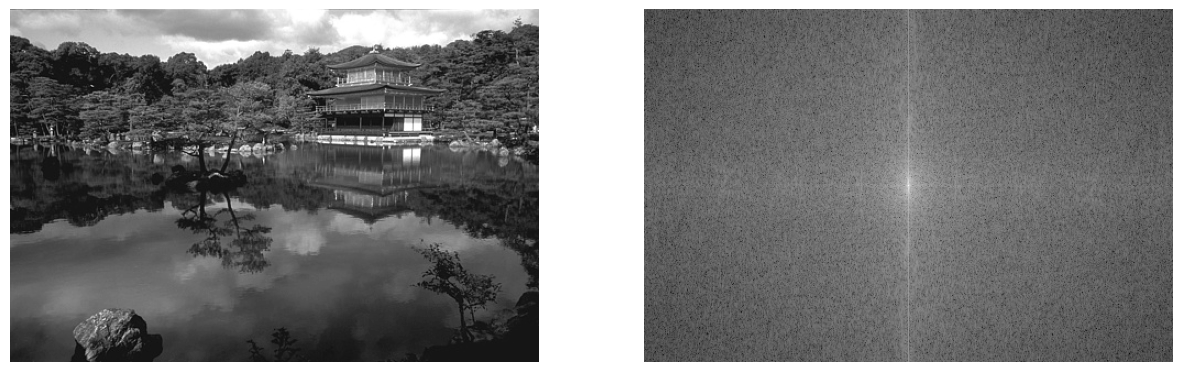

In [2]:
from skimage import io
from scipy.fftpack import fft2, ifft2, fftshift
from skimage import color

img = io.imread("./images/behringer.png")
img = io.imread("./images/65010.jpg")
img_bw = color.rgb2gray(img[:, :, :3])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
F_img_bw = fftshift(fft2(img_bw))
axs[0].imshow(img_bw, cmap='gray')
axs[1].imshow(np.log(np.abs(F_img_bw)), cmap='gray')
for ax in axs: ax.axis('off')

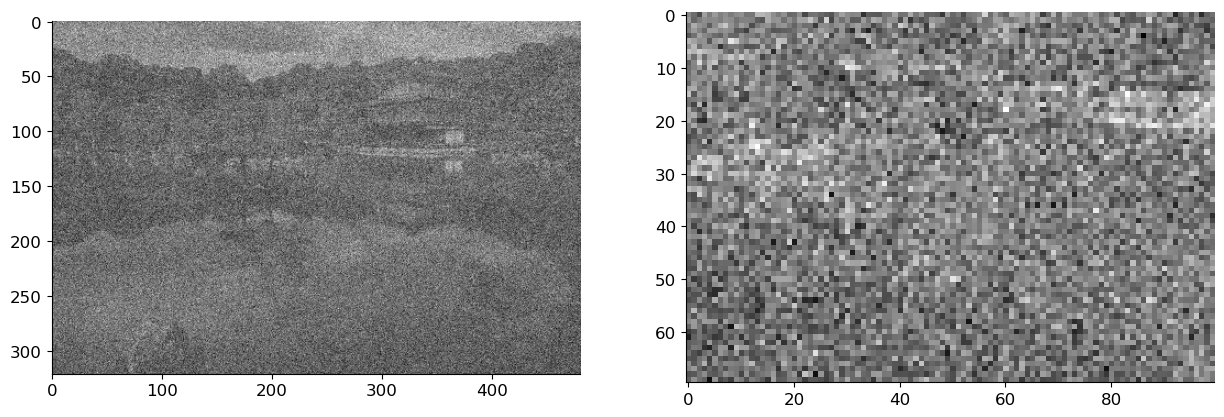

In [3]:
img_bw /= img_bw.max()
img_bw -= img_bw.mean()
sigma = 0.3
img_noise = img_bw + sigma*np.random.randn(*img_bw.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(img_noise, cmap='gray')
# axs[1].imshow(img_noise[500:875, 1000:1500], cmap='gray');
axs[1].imshow(img_noise[100:170, 200:300], cmap='gray');

Our task will be to denoise the noisy image. A quick-and-dirty strategy we've already seen at work for boundary detection is to apply a bit of Gaussian blur.

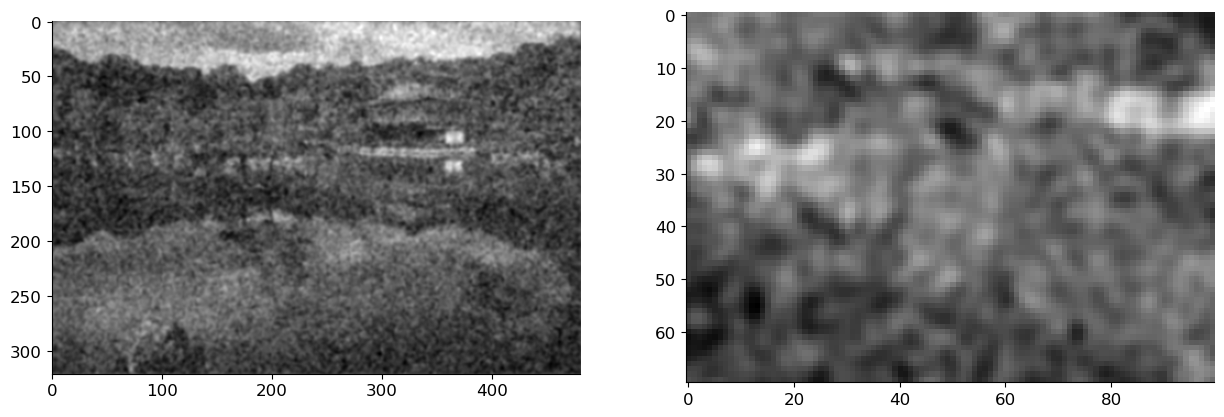

In [4]:
from scipy.signal import gaussian, convolve2d
from scipy.signal import fftconvolve

kernel_size = 7
h = gaussian(kernel_size, kernel_size / 5).reshape(kernel_size, 1)
h = np.dot(h, h.T)
h /= np.sum(h)
    
x_hat = fftconvolve(img_noise, h, mode='same')

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_hat, cmap='gray')
axs[1].imshow(x_hat[100:170, 200:300], cmap='gray');

This seems to indeed remove some noise (as well as signal), but is it the best we can do? As we've already seen a couple of times, answering this question will force us to define what we mean by _best_.

We model the clean image, the noise, and the noisy image as $d$-dimensional random vectors $\rvx$, $\rvw$, $\rvy$ and write

$$
  \rvy = \rvx + \rvw.
$$

Note that we are using our notation for a random vector rather than a random matrix. The reason for this is that we think of matrices as operators that are being applied to a vector. On the other hand we never want to "apply an image to a vector". It is more useful to conserve the semantics of operators and vectors than the fact that images are 2D arrays of numbers.

Another thing to note is that we model the uncorrupted images $\rvx$ as a random vector. This will be useful.

At this point the efforts we invested into understanding (Bayesian) linear regression will pay of a handsome dividend. We want to build an estimator $\hat{\rvx} = \hat{\rvx}(\rvy)$ of the underlying clean image $\rvx$. We want this estimator to be optimal in some sense, so we have to choose a quality metric. It is common to choose the mean-squared error (MSE) which is given for any estimator as

$$
  \mathrm{MSE}(\hat{\rvx}) = \EE ~ \norm{\hat{\rvx} - \rvx}^2.
$$

We then want to find an estimator which achieves the smallest possible MSE. It is possible to show that this minimum-MSE (MMSE) estimator is given as the conditional expectation

$$
  \hat{\rvx} = \EE [\rvx \mid \rvy] = \int \vx p(\vx | \rvy) d \vx.
$$

Indeed, we can compute as follows (recall that the estimate $\hat{\rvx}$ is _some_ function of the "observation" $\rvy$ so we write $\hat{\rvx} = g(\rvy)$),

$$
\begin{aligned}
  \EE ~ \norm{\hat{\rvx} - \rvx}^2 
  &= \EE ~ \norm{\hat{\rvx} - \rvx}^2 \\
  &= \EE\left\{ \EE \left[\norm{g(\rvy) - \rvx}^2 \mid \rvy \right]\right\},
\end{aligned}
$$
where we used the so-called tower property of conditional expectation, also known as the law of iterated expectation. A rigorous definition is quite technical, but we don't have to worry about it here. What is says in a nutshell is that the unconditional expectation can be computed by first computing the conditional expectation and then averaging all together. It expresses the following formal calculation:

$$
\begin{align}
  \int f(\vx, \vy) p_{\rvx, \rvy}(\vx, \vy) d\vx d\vy
\end{align}
$$

What this means effectively is that we can focus on the inner expectation and try to minimize it for each $\vy$ independently (since that will guarantee that the outer expectation or the outer integral is also the smallest possible). So we'd like to solve

$$
\begin{aligned}
  \min_{g(\vy)} \EE \left[\norm{g(\vy) - \rvx}^2 \mid \rvy = \vy \right]
\end{aligned}
$$

Taking the derivative (gradient) with respect to $g(\vy)$ (note that this is just some fixed vector which we could call anything we like, for example $\vv$) and setting to zero yields

$$
  2 \EE [ (g(\vy) - \rvx) \mid \rvy = \vy] = 0
  \Rightarrow
  g(\vy) = \EE [\rvx \mid \rvy = \vy].
$$

Now we've got our function $g$. Here $g$ is applied to a fixed vector $\vy$; in estimation we apply it to the random noisy observation $\rvy$ so we write

$$
  \hat{\rvx} = g(\rvy) = \EE [\rvx \mid \rvy].
$$

This formula holds generally, for any jointly distributed random vectors $\rvx$ and $\rvy$, not only for the additive noise model. It can be simplified in the latter case. This is quite fantastic, but in order to compute this optimal estimate it now turns out that we need to know the joint distribution of $(\rvx, \rvy)$, or at least the distribution of $\rvx$ conditioned on $\rvy$. In problems with real images this distribution is very complicated and we do not know it. It is also complicated to estimate from data.

### LMMSE Estimation

One problem with the above scheme is that there were no constraints on the estimator function (algorithm) $g$. Since $g$ can be very general, it can truly exploit the fine properties of the conditional probability distribution. We now try something different: we constrain $g$ to be a linear (or more precisely, affine) function.

Let $\vmu = \EE \rvx = \EE \rvy$ (recall that we work with zero-mean noise). We will look for an estimate of $\rvx$ of the form

$$
  \hat{\rvx} = \mH (\rvy - \vmu) + \vmu.
$$

(The reason to subtract the mean is to improve the conditioning of $\mH$. TODO: add a picture.) We want to find the matrix $\mH$ which gives the best MSE:

$$
  \mathrm{minimize}_{\mH \in \RR^{d \times d}} \EE \| \mH(\rvy - \vmu) + \vmu - \rvx \|^2.
$$

By taking the gradient of the loss with respect to $\mH$ and setting it to zero, we find that the optimal $\mH$ is

$$
  \mH = \mSigma_{\rvx\rvx} (\mSigma_{\rvx\rvx} + \sigma^2 \mI)^{-1},
$$

where $\mSigma_{\rvx\rvx}$ is the covariance matrix of the random vector $\rvx$,

$$
  \mSigma_{\rvx\rvx} = \EE (\rvx - \vmu) (\rvx - \vmu)^T.
$$

The LMMSE estimator is thus given as

$$
  \hat{\rvx} = \mSigma_{\rvx\rvx} (\mSigma_{\rvx\rvx} + \sigma^2 \mI)^{-1} (\rvy - \vmu) + \vmu
$$

This is noteworthy: if we restrict the class of estimators $g$ to only linear estimators, then we do not need to know the distribution of $\rvx$ but only its mean and covariance matrix. Mean and covariance are in general much simpler to estimate than the full distribution.

Instead of the additive Gaussian noise model, we could have simply started with some jointly distributed random vectors $(\rvx, \rvy)$. The LMMSE estimator would then read

$$
  \hat{\rvx} = \mH (\rvy - \vmu_\rvy) + \vmu_\rvx,
$$

where 

$$
\begin{align}
  \mH &= \mSigma_{\rvx \rvy} \mSigma_{\rvy \rvy}^{-1}\\
  \mSigma_{\rvx \rvy} &= \EE (\rvx - \vmu_\rvx)(\rvy - \vmu_\rvy)^T\\
  \mSigma_{\rvy \rvy} &= \EE (\rvy - \vmu_\rvy)(\rvy - \vmu_\rvy)^T.
\end{align}
$$

Check that this is indeed the case following the template we laid down earlier. You might need this someday! The previous result for additive white Gaussian noise follows immediately.

It is also interesting to record the actual MSE achieved by the LMMSE estimator. It is given as

$$
\begin{aligned}
  \mathrm{LMMSE} 
  &= \mathrm{Tr} (\mSigma_{\rvx\rvx} - \mSigma_{\hat{\rvx} \hat{\rvx}}) \\
  &= \sum_{i=1}^d \left[\mathrm{Var}(\rx_i) - \mathrm{Var}(\hat{\rx}_i)\right] \\
  &= \sum_{i=1}^d \left[\EE(\rx_i^2) - \EE(\hat{\rx}_i^2)\right].
\end{aligned}
$$

Do check that these equalities really hold!

A final note about Gaussianity. We've seen that the LMMSE estimator only needs means and covariances. Gaussian distributions are completely determined by means and covariances. In fact, one can show that when $\rvx$ and $\rvy$ are jointly Gaussian random vectors, then the LMMSE estimator is in fact the MMSE estimator.

## Wiener filter

The LMMSE estimator is sometimes called the Wiener filter, but the real Wiener filter usually implies a little bit more. To motivate this ``little bit more'', let us consider how we could estimate the matrix $\mSigma_{\rvx\rvx}$ (or any of the other involved covariance matrices). We would usually have a dataset of images $\{\vx_1, \ldots, \vx_n\}$ that we believe are iid samples from the unknown underlying distribution of $\rvx$. We would then form an estimate of the covariance as 

$$
  \hat{\mSigma}_{\rvx\rvx} = \frac{1}{n} \sum_{i=1}^n (\vx_i - \hat{\vmu}_\rvx)( \vx_i - \hat{\vmu}_\rvx)^T,
$$

where

$$
  \hat{\mu}_{\rvx} = \frac{1}{n} \sum_{i=1}^n \vx_i.
$$

Sometimes you will see the factor $\frac{1}{n}$ replaced by $\frac{1}{n-1}$ in the covariance estimate (but not the mean estimate). For our purpose that is irrelevant (it yields an ``unbiased'' estimate).

Now if we work with $256 \times 256$ RGB images, the dimension of $\vx_i$ is 

$$ 
  d = 256 \times 256 \times 3 = 196,608.
$$

The covariance matrix is thus of dimensions $d \times d = 196,608 \times 196,608$ which is huge. There are about $38,654,705,664 / 2$ entries to estimate (it's a symmetric matrix), and this requires an enormous training set. Further, manipulating a matrix of this size (say, inverting it) is very very challenging on standard hardware.

The saving grace comes from noting that a good denoising operator should perform a similar operation in every part of the vector. If we additionally want it to be linear, then we can further constrain the class of admissible estimators to convolutional filters. In other words, we can further constrain the matrix (the linear operator) $\mH$ to be a convolution matrix. (TODO: update the notation table.) Letting $h[n]$ be the corresponding impulse response, and $\rx[n], \ry[n], \rw[n]$ be the $n^{th}$ components of  vectors $\rvx, \rvy, \rvw$, we then have

$$
  \hat{\rx}[n] = (\ry \circledast \rh)[n].
$$

Ultimately we want to use linear convolution, but let us for the moment pretend that circular convolution is fine since it will simplify the derivations. (TODO: use $2N$ below.) Applying the discrete Fourier transform on both sides we get

$$
  \hat{\rX}[k] = \rY[k] \cdot H[k]
$$ (dft-wiener)

where we use the upper case to denote the corresponding DFTs. The key benefit of passing to the (discrete) frequency domain is that the frequency-domain filter coefficient become independent of one another. In other words, in the equation {eq}`dft-wiener` we can choose each of the $\rH[k]$ independently of all others, and it will only depend on $\rX[k]$ and $\rY[k]$ for that particular $k$. To see this we use the Parseval equality. Indeed, since

$$
  \EE \sum_{n \in \ZZ_d} (\rx[n] - \hat{\rx}[n])^2
  =
  \frac{1}{d} \EE \sum_{k \in \ZZ_d} (\rX[k] - \hat{\rX}[k])^2  
$$
we can do our minimization in the frequency domain where it now simply reads

$$
  \min_{H} \EE \sum_{k \in \ZZ_d} (H[k] \rY[k] - \rX[k])^2
  =
  \min_{H} \sum_{k \in \ZZ_d} \EE |H[k] \rY[k] - \rX[k]|^2
$$

which can indeed be solved for each $k$ independently. Note that we have to put $\| \cdot \|$ around the terms in the frequency domain since they are in general complex. Taking the derivative with respect to the real and imaginary parts of $H[\ell]$ and setting them to zero yields (do check this!)

$$
  \EE (H[\ell] Y[\ell] - X[\ell]) Y^*[\ell] = 0,
$$

so that

$$
  H[\ell] = \frac{S_{XY}[\ell]}{S_{YY}[\ell]},
$$
where $S_{XY}[\ell] = \EE ~ X[\ell] Y^*[\ell]$ and $S_{YY}[\ell] = \EE ~ Y[\ell] Y^*[\ell]$.

For additive white Gaussian noise we have that (do check the following as well!)

$$
  S_{XY}[\ell] = S_{XX}[\ell] = \EE ~ X[\ell] Y^*[\ell]
$$

and

$$
  S_{YY}[\ell] = S_{XX}[\ell] + S_{WW}[\ell] =  S_{XX}[\ell] + d \sigma^2
$$

so that

$$
  H[\ell] = \frac{S_{XX}[\ell]}{S_{XX}[\ell] + d \sigma^2}
$$

We can now identify an implicit assumption, or an alternative route that would've yielded a convolutional filter model. The DFT of the impulse response of the optimal filter is obtained for each $\vell$ individually. The expression is completely parallel to the matrix expression we derived earlier for general LMMSE estimators, but unlike in that general case, the $\vell$-th output now depends only on the variance of the $\vell$-th spectral bin, but not on the other ones. We can thus still write a matrix version of the above expression but that matrix version will be quite special:

$$
\begin{aligned}
  \begin{bmatrix} 
    H[0] & &  \\
    &  \ddots &   \\
     &  & H[d - 1]
  \end{bmatrix}
  & =
  \begin{bmatrix} 
    S_{XX}[0] & &  \\
    &  \ddots &   \\
     &  & S_{XX}[d - 1]
  \end{bmatrix}\\
  &\times\left(
  \begin{bmatrix}
        S_{XX}[0] & &  \\
    &  \ddots &   \\
     &  & S_{XX}[d - 1]  
  \end{bmatrix}\\
  +
  \sigma^2 d^2
  \begin{bmatrix}
        1 & &  \\
    &  \ddots &   \\
     &  & 1 
  \end{bmatrix}
  \right)^{-1}
\end{aligned}
$$
(All matrices are diagonal.) We did something seemingly crazy: we took a perfectly nice _scalar_ expression and we rewrote with matrices. But the reason to do this is that it is now clear that this expression has precisely the form

$$
  \mH = \mSigma_{\rX \rX} ( \mSigma_{\rX \rX} + \sigma^2 \mI)^{-1}
$$

which we encountered earlier, but with all covariance matrices (which are now between the different discrete frequencies) being diagonal. For two frequencies $\ell \neq k$ it holds that 

$$
  \EE ~ \rX[\ell] \rX[k] = 0,
$$

hence the zero off-diagonal elements. This means that our tacit assumption in using a convolutional filter is that the different frequencies are _uncorrelated_ (or even, in the Gaussian case, _independent_!). Looking back at the derivations, this makes intuitive sense since convolutional filters cannot create new frequencies, and by the convolution–multiplication rule the output at a given frequency is only affected by the input at that frequency.

Another equivalent perspective (which is important but we will not explore it in depth here) is via the notion of stationarity, and in particular _wide-sense stationarity_. A random signal $\rx[n]$ is wide-sense stationarity if its mean $\EE ~ \rx[n]$ is constant in $n$ and its autocorrelation function $\EE ~ \rx[n] \rx[m]$ only depends on the distance $m - n$. In other words the function 

$$
  a_{\rx \rx}[t] = \EE ~ \rx[n] \rx[n + t] 
$$

does not depend on $n$. It is easy to check that the above $S_{\rX \rX}$ is the Fourier transform of $a_{\rx \rx}$. (Check if this needs a zero mean assumption.)

**Note:** The above derivation can be extended to 2D signals (images) without much difficulty.

Now, let's use the Wiener filter approach to denoise the noisy image, which we used earlier and compare it with Gaussian filtering. We use the Fourier version of the Wiener filter to denoise the image. For simplicity we assume that we know the power spectrum of the image, there are multiple methods of estimating this power spectrum, which we do not delve into here.

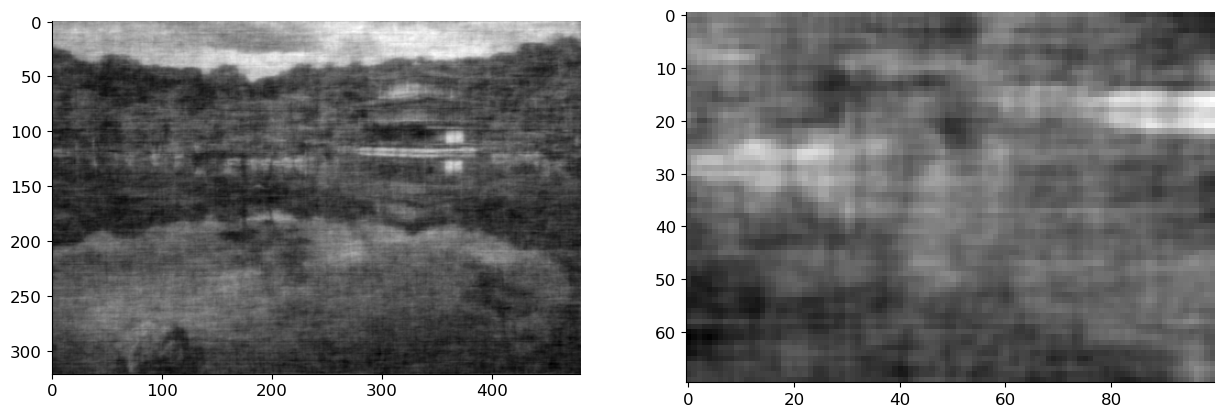

In [5]:
from scipy.fftpack import fft2, ifft2, fftshift


def wf(y, SXX, sigma):
   F_y = fft2(y)
   F_wiener = SXX / (SXX + np.prod(y.shape) * sigma**2)
   F_x_hat = F_y * F_wiener
   x_hat = np.real(ifft2(F_x_hat))
   return x_hat, np.real(ifft2(F_wiener, y.shape))



##Assume the power spectrum is given 

SXX = np.abs(fft2(img_bw))**2

img_est, filt = wf(img_noise, SXX, sigma=sigma)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(img_est, cmap='gray')
axs[1].imshow(img_est[100:170, 200:300], cmap='gray');   

Images estimated using a Gaussian blur and Wiener filter looks slightly different from the original image. So, to compare them quantitatively, we compute the $\ell_2$-norm of the distance between them.

In [6]:
print('Wiener Filter: ',np.linalg.norm(img_est - img_bw))
print('Gaussian Blurring:',np.linalg.norm(x_hat - img_bw))
print('Noisy Image:',np.linalg.norm(img_noise - img_bw))

Wiener Filter:  27.463046803509673
Gaussian Blurring: 32.70456088584626
Noisy Image: 117.79123291268496


We can clearly observe that image estimated using the Wiener filter is much closer compare to that of the Guassian blur.



## Deblurring

Another common image degradation mechanism is blurring (due to out-of-focus imaging, atmospheric or other point-spread functions, lens blur, motion blur, ...). Typically, the image is blurred and then corrupted with noise. The goal is to recover the original image. Here, we first model the blurring process and then derive an optimal estimator to deblur the image and then denoise it.  Specifically, we derive a Wiener filter for deblurring and denoising.


First, lets see how the blurring effects an image.

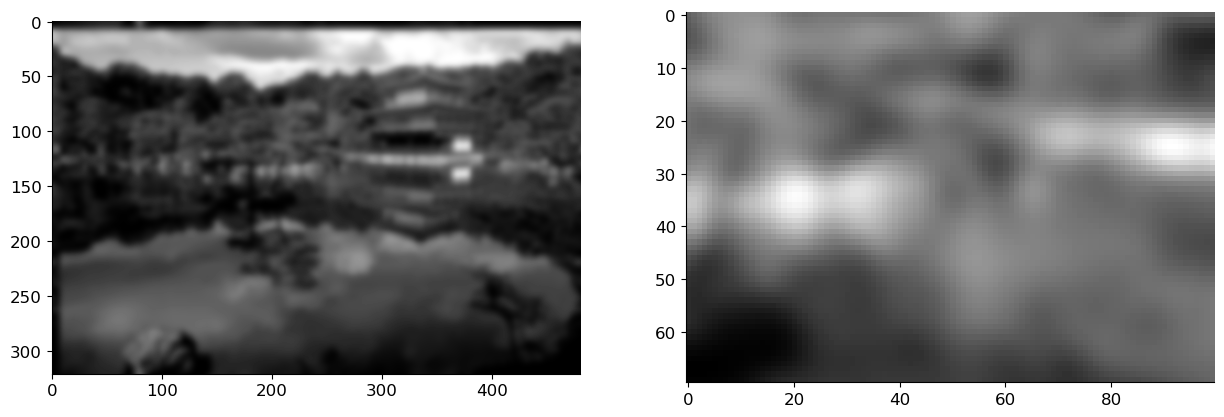

In [7]:
from scipy.signal import gaussian, convolve2d
from scipy.signal import fftconvolve

kernel_size = 15
h_gauss = gaussian(kernel_size, kernel_size / 5).reshape(kernel_size, 1)
h_gauss = np.dot(h_gauss, h_gauss.transpose())
h_gauss /= np.sum(h_gauss)

# circular convolution for simplicity
x_blur = ifft2(fft2(h_gauss, img_bw.shape) * fft2(img_bw)).real

H_brutal = np.zeros(img_bw.shape)


x_blur = ifft2(fft2(h_gauss, img_bw.shape) * fft2(img_bw)).real

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_blur, cmap='gray')
axs[1].imshow(x_blur[100:170, 200:300], cmap='gray');

A simple way of looking at blurring is that we are averaging a pixel using the value of it neighbours. Thus blurring is a linear operation. For an image $\vx$, let us assume that $\mB$ is a blurring matrix. Then the blurred image is obtained as:

$$
 \vy = \mB \vx
$$

In practice, a convolutional filter can be used to simulate this blurring. Assuming we know this filter, the Fourier trasnform of the blurred image is, using the filter and the original image is:

$$
Y[\vk] = B[\vk]X[\vk]
$$
Where $\vk = [k_1, k_2]$ are the 2-D Fourier indeces. From the above equation we can see that if we know the blur filter, we can obtain the image by just dividing the blurred image with the filter coefficient in the Fourier Domain. We use this simple deblurring strategy on the above image.

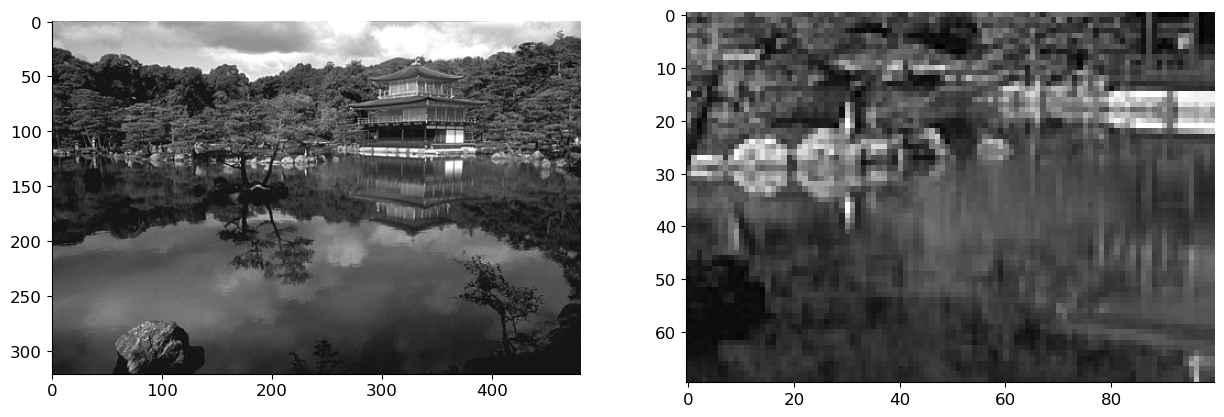

In [8]:
 # simple deblurring (deconvolution)

x_deblurred = ifft2(fft2(x_blur) / fft2(h_gauss, img_bw.shape)).real
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_deblurred, cmap='gray')
axs[1].imshow(x_deblurred[100:170, 200:300], cmap='gray');

In practice, we have some noise on the  observed image along with it being blurred. We can represent this as:

$$
 \vy = \mB\vx + \vw
$$

Where $\vw$ is the noise of known variance $\sigma^2$.The above eqaution in Fourier domain can be represented as:
$$
Y[\vk] = B[\vk]X[\vk] + W[\vk]
$$

Lets, try the previous procedure  for  deblurring and see how it works:

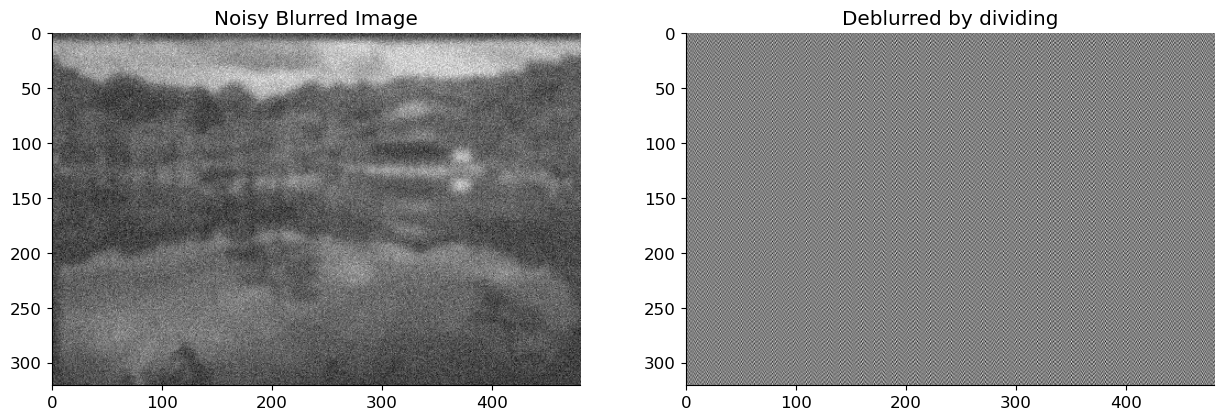

In [9]:
 sig = 0.1
x_blur_n = x_blur + sig*np.random.randn(*x_blur.shape)
x_deblurred_n = ifft2(fft2(x_blur_n) / fft2(h_gauss, img_bw.shape)).real

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_blur_n, cmap='gray')
axs[0].title.set_text('Noisy Blurred Image')
axs[1].imshow(x_deblurred_n, cmap='gray');
axs[1].title.set_text('Deblurred by dividing')

Thus, dividing by the fourier coefficient yields an estimate that differs greatly from the original image. This is due to the fact that we do not account for noise, and these noisy coefficients can be amplified simply by dividing them. As a result, while performing the deblurring operation, we must consider the noise. In the following section, we derive the Wiener filter coefficient for deblurring using the blurring filter and statistical properties of the noise.

### Deblurring using Wiener filter
For simplicity,  assume that we  are operating on 1-D signals. This can be easily extended to images or any higher-dimensional signals. Let $x[n],y[n]$ be the image and the blurred image, let $b[n]$ be the impulse reponse of the blurring fitler. For simplicity we assume circular convolution for blurring. Thus we observe:

$$
y[n] = (x \circledast b)[n] + w[n] 
$$

Thus to obtain the original signal $x[n]$, we apply a filter $h[n]$ on the obervation $y[n]$. Applying the Discrete Fourier Transform (DFT), we obtain the estimated signal $\tilde{x}[n]$ as:

$$
  \tilde{X}[k] = H[k]Y[k]
$$

Where $\tilde{X}[k], Y[k]$ and $H[k]$ are the DFTs of the signal $\tilde{x}[n], y[n]$ and $h[n]$ respectively. As we obtained the filter for denoising, we perform the same operation to obtain the filter coefficients for deblurring. Thus we obtain the Wiener filter as:

$$
H[\ell] = \frac{S_{XY}[\ell]}{S_{YY}[\ell]}
$$
where $S_{XY}[\ell] = \EE ~ X[\ell] Y^*[\ell]$ and $S_{YY}[\ell] = \EE ~ Y[\ell] Y^*[\ell]$.

For additive white Gaussian noise  and the Blurr filter $B$, we have (do check this!):

$$
\begin{aligned}
S_{XY}[\ell] &= \EE ~ X[\ell] Y^*[\ell] = \EE ~ X[\ell] (H^*[\ell]X^*[\ell] + W[\ell] ) \\
&= H^*[\ell] \EE ~ [X[\ell] X^*[\ell] ] \\
&= H^*[\ell] S_{XX}[\ell]
\end{aligned}
$$

and 

$$
S_{YY}[\ell] = |H[\ell]|^2 S_{XX}[\ell] + d\sigma^2
$$

so that: 

$$
  H[\ell] = \frac{H^*[\ell]S_{XX}[\ell]}{ |H[\ell]|^2 S_{XX}[\ell] + d \sigma^2}
$$

Using the above experssion for deblurring filter, we experiment on the noisy image used previously:

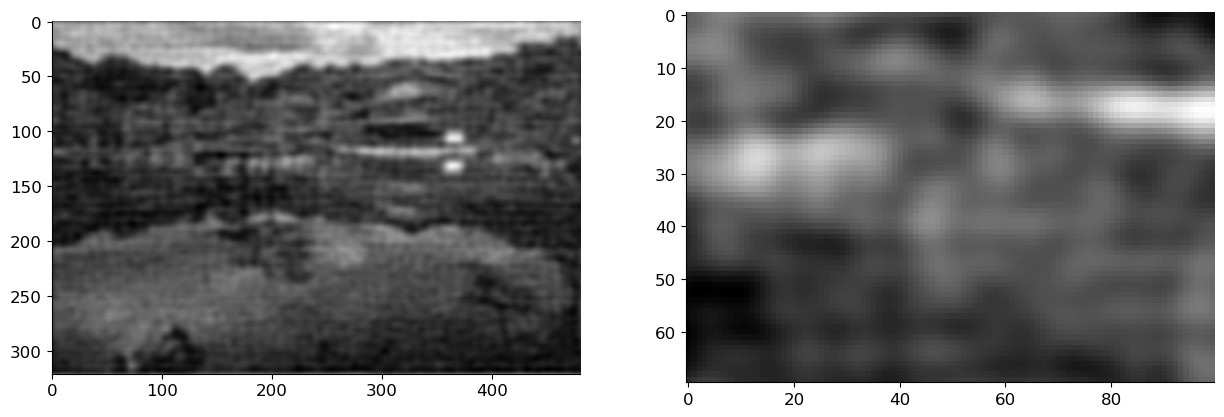

In [10]:
 def wf(y, SXX, sigma, ker=np.ones((1, 1))):
    F_y = fft2(y)
    F_ker = fft2(ker, shape=y.shape)
    F_wiener = np.conj(F_ker)*SXX / ( SXX*np.abs(F_ker)**2 + np.prod(y.shape) * sigma**2)
    F_x_hat = F_y * F_wiener
    x_hat = np.real(ifft2(F_x_hat))
    return x_hat, np.real(ifft2(F_wiener))


x_wiener, filt2 = wf(x_blur_n, SXX, sig, ker=h_gauss)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_wiener, cmap='gray')
axs[1].imshow(x_wiener[100:170, 200:300], cmap='gray');

## Wiener Filtering for Audio Signals
Now, we look at an application of Wiener filtering for  removing high frequency noise from audio signals. We first load the audio.

In [11]:
from scipy.io import wavfile
from IPython.lib.display import Audio

fs, x = wavfile.read('./audio/german-anechoic.wav')
x = x[:, 0]
Audio(x, rate=fs, autoplay=False)

Next, we add a high-frequency noise to the audio.

In [12]:
from scipy.signal import gaussian, butter, sosfilt

x = x / np.abs(x).max()
sigma = 3

noise = sigma*np.random.randn(*x.shape)
cutoff_freq = 200
sos = butter(30, cutoff_freq, 'hp', fs=fs, output='sos')
noise = sosfilt(sos, noise)

y = x + noise

Audio(y, rate=fs, autoplay=False) 

We now apply the Wiener filter to the noisy signal. We first compute the power spectral density of the signal and the noise.  We use $L$ length filter to remove the noise.  Thus we need  power spectral density (PSD) estimated for length $L$. For a length $L$ estimate of a filter the parameters we need are $\EE ~ y[n]y[n-l]$ and $\EE ~ x[n]y[n-l]$ for $l = 0,1,\dots, L$. Using the stationarity assumptions of the signal, we can estimate $\EE ~ y[n]y[n-l]$ as:

$$
\begin{aligned}
\EE ~ y[n]y[n-l] \approx \frac{1}{N-L} \sum_{n=L}^{N} y[n]y[n-l] \\
\end{aligned}
$$

Where $N$ is the length of the signal. We can estimate the $\EE ~ x[n]y[n-l]$ as:

$$

\EE ~ x[n]y[n-l] \approx \frac{1}{N-L} \sum_{n=0}^{N-L} x[n]y[n-l] 

$$

Using the estimates we can obtain the Wiener filter. We then apply the filter to the noisy signal and listen to the result.

In [13]:
# from tqdm import tqdm
from scipy.linalg import toeplitz

L = 1000
N = len(x)

# this can be done fast with stride tricks but it's more didactic here
# also: we're doing a bit of a cheat assuming that we have oracle access to the clean signal...

r_yy = np.zeros((L + 1,))
r_xy = np.zeros((L + 1,))
for i in range(N - L):
    frame_x = np.flip(x[i:i + L + 1])
    frame_y = np.flip(y[i:i + L + 1])
    r_yy += frame_y[0] * frame_y
    r_xy += frame_x[0] * frame_y
r_yy /= (N - L)
r_xy /= (N - L)

R_yy = toeplitz(r_yy)
h = np.linalg.solve(R_yy, r_xy) 

Alternatively, we can use FFT's to speed up the computation. We first compute the $N$ length signal corresponding to the autocorrelation of the signal $y[n]$ and the cross-correlation of the signal $x[n]$ and $y[n]$. We then keep only the first $L$ components of the signal as we are only interested in the autocorrelation of the signal $y[n]$ and the cross-correlation of the signal $x[n]$ and $y[n]$ for $l = 0,1,\dots, L$. We then use the Toeplitz matrix structure of the autocorrelation and cross-correlation to compute the Wiener filter. We then apply the filter to the noisy signal and listen to the result.

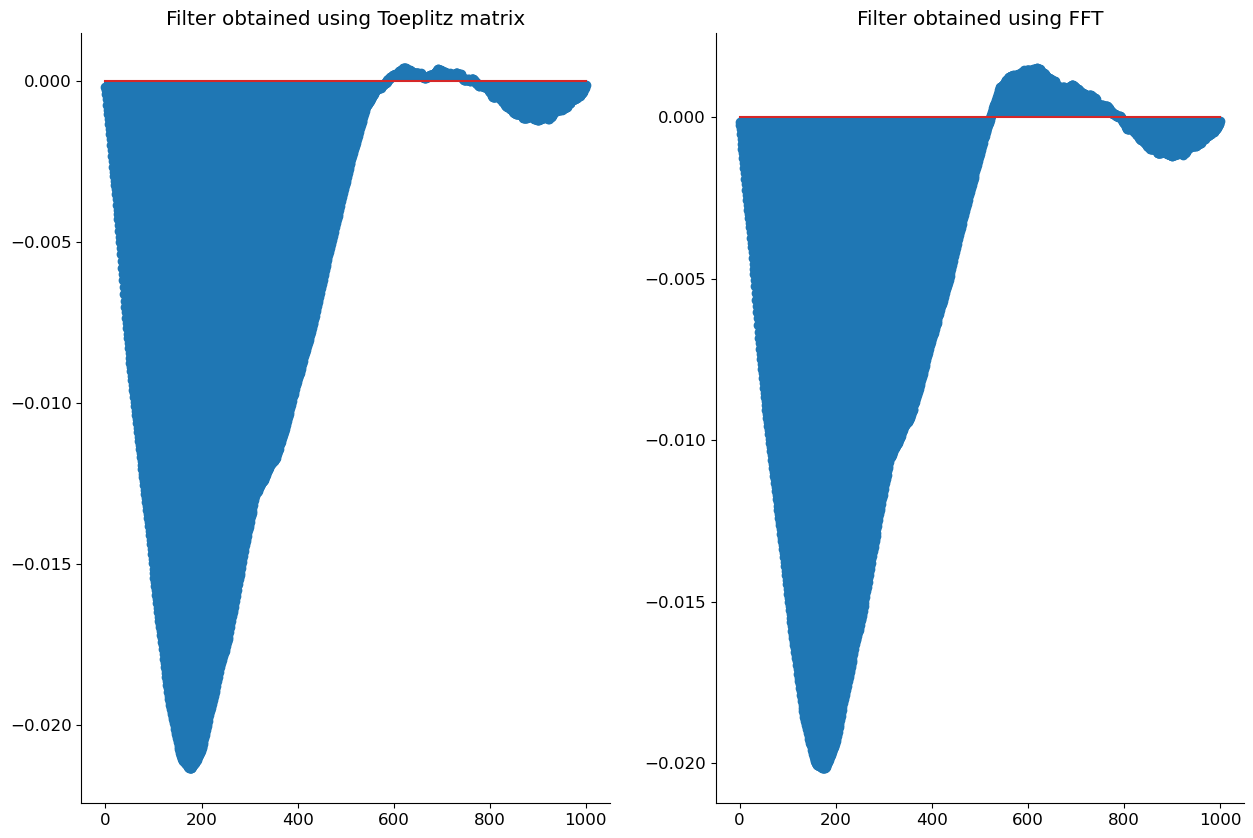

In [14]:
from scipy.fftpack import fft, ifft
from scipy.signal import fftconvolve


Y = fft(y, 2*N);
X = fft(x, 2*N);
 
R = np.real(ifft(Y * np.conj(Y)))[:L + 1]
Ryy = toeplitz(R)
r = np.real(ifft(X * np.conj(Y)))
r = r[:L + 1]

h_opt = np.linalg.solve(Ryy, r)


x_hat = fftconvolve(y, h_opt, 'same')
Audio(x_hat, rate=fs, autoplay=False)

# Plot comparing the two filters
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].stem(h)
axs[0].set_title('Filter obtained using Toeplitz matrix')
axs[1].stem(h_opt)
axs[1].set_title('Filter obtained using FFT')
plt.show()

## Effects of circular convolution
Circular convolution is a special case of convolution where the signal is assumed to be periodic. Lets consider a signal $x[n]$ with period $N$. The periodicity of the signal implies that $x[n] = x[n+N]$. We consider another signal $h[n]$ (Impulse signal), with support $[0, N-1]$. This implies that $h[n] = 0$ for $n < 0$ and $n > N-1$. The convolution of the two signals is given by:

$$
y[n] = \sum_{m=0}^{N-1} h[m] x[n-m] \tag*{(Finite support of $h[n]$)}
$$

You can observe that as $x[n]$ is peridoic, the convolved signal $y[n]$ is also periodic with period $N$.



$$
  \begin{aligned}
  y[n+N]  &= \sum_{m=0}^{N-1} h[m] x[n-m+N] \\
  &= \sum_{m=0}^{N-1} h[m] x[n-m]  && \text{($x$ being periodic)} \\ 
  &= y[n] 
  \end{aligned}
$$

Now, lets consider a periodic extension of the signal $h[n]$. This can be done by repeating the signal, $\tilde{h}[n] = h[n \mod N]$. Using this periodic extension, we define the circular convolution as follows( TODO: Add reference to Foundations of Signal Processing):

$$
\begin{aligned}
(x \ast h)[n] &= \sum_{m = -\infty}^{\infty} h[m] x[n-m]  \\
&= \sum_{l = -\infty}^{\infty} \sum_{m = lN}^{(l+1)N-1} h[m] x[n-m]   && \text{(Splitting the sum to periods)}\\
&= \sum_{l = -\infty}^{\infty} h[m'+lN]x[n - m' - lN] &&\text{(Substitute: } m' = m + lN)    \\
&= \sum_{m'= 0}^{N-1 } \sum_{l = -\infty}^{\infty}h[m'+lN] x[n - m'] && \text{($x[n]$ is periodic)} \\
&= \sum_{m'= 0}^{N-1 } \tilde{h}[m'] x[n - m'] && \text{($h[n \mod N] = \sum_{l = -\infty}^{\infty}h[n+lN]$ )} \\
&= (\tilde{h} \circledast x)[n]
\end{aligned} 
$$

The above derivation shows that the circular convolution is equivalent to the convolution of the periodic extension of the signal $h[n]$ with the signal $x[n]$. Thus the circular convolution is a special case of convolution. As the signals are periodic, to compute circular convolution we only need to look at elements of the signal and the impulse reponse within  a single Period. Thus circular convolution can be seen as a convolution where indeces are from a finite field $\ZZ_N$.

In practice, we only work with finite length signals. Thus when we compute the circular convolution we assume that the signal is periodic with period equal to the length of the signal. Thus for a finite length signal $x[n]$ circularly convolving with a an impulse response, with small support can introduce edge effects. That is, value at the beginning of the signal is affected by the values at the end of the signal and vice versa. 

Circular comvolution can be computed efficiently using the Fast Fourier Transform (FFT), the reason being that FFTs implicitly assume periodicity of the signal. Thus the FFT of the signal is computed and then the FFT of the impulse response is multiplied with the FFT of the signal. The inverse FFT of the product gives the circular convolution of the signal with the impulse response. Computational complexity of a Circular convolution using FFT is  $O(N \log N)$, where $N$ is the length of the signal. This is much faster than the naive implementation of the circular convolution which takes $O(N^2)$ operations.



## Impulse Response
In this, chapter we used the impulse response, to derive several Wiener filter results. Now, we look at the definition of impulse reponse. 

Impulse response is defined as the response of the system when we apply a delta function as input to it. We will consider only discrete time systems. The delta function is defined as:

$$
\delta[n] = \begin{cases}
    1,& \text{if } n= 0\\
    0,              & \text{otherwise}
\end{cases}
$$


For a system $S$, the impulse response is defined as:

$$
  h[n] = S(\delta)[n]
$$

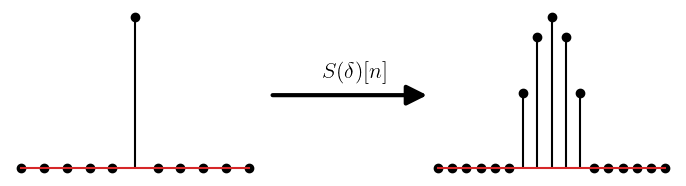

In [15]:
#Impulse response of the system
N = 11
delta =np.zeros(N)
delta[N//2] = 1
h = np.cos(np.linspace(-np.pi/2,np.pi/2,7))
y = np.convolve(delta,h) # output of the system

from matplotlib import patches, pyplot as plt
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(10,5))

# First subplot
ax1 = fig.add_subplot(121)
plt.stem(delta,linefmt='black',markerfmt='ko')
ax1.axis('off')
#ax1.set_title(r'$\delta[n]$',y=-0.1)


# Second subplot
ax2 = fig.add_subplot(122)
plt.stem(y,linefmt='black',markerfmt='ko')
ax2.axis('off')
#ax2.set_title(r'$h[n]$',y=-0.1)
# Add line from one subplot to the other
xyA = [9, 0.5]
#ax1.plot(*xyA, "o")
xyB = [1, 0.5]
#ax2.plot(*xyB, "o")
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(ax1.transData.transform(xyA))
coord2 = transFigure.transform(ax2.transData.transform(xyB))
arrow = patches.FancyArrowPatch(
    coord1,  # posA
    coord2,  # posB
    shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
    shrinkB=0,  # so head is exactly on posB (default shrink is 2)
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=30,  # controls arrow head size
    linewidth=3,
    label=r'$S(\delta)[n]$',
)
fig.patches.append(arrow)
fig.tight_layout(pad=10)
leg = plt.legend(handles = [arrow], fontsize=16, frameon=False, loc=(-0.7, 0.5)) # Locations Manually adjusted
for item in leg.legendHandles:
    item.set_visible(False)




There exists a broad class of  systems called the linear time invariant (LTI) systems. These systems are characterized by the following properties:

- Linearity: For input signals $x_1[n]$, and $x_2[n]$ and scalars $a,b$, we have:  $S(a x_1 + b x_2)[n] = a S(x_1)[n] + b S(x_2)[n]$
- Time Invariance: For any input signal $x[n]$, if the output is $y[n] = S(x)[n]$, then the output of the system for the delayed signal $\tilde{x}[n] = x[n - k]$ is 

$$\tilde{y}[n] = S(\tilde{x})[n] = S(x)[n-k] = y[n-k]$$


For such systems, the  impulse response completely characterizes it. That is, we can predict the output of the system for any input $x[n]$, using its impulse resonse $h[n]$.  Thus the impulse response is the most important property of an LTI system. 

Lets, see how this is true for the for an LTI system $S(\cdot)$. The impulse reponse is $h[n] = S(\delta)[n]$. Any input signal $x[n]$  can be written interms of the delta function as:

$$
x[n] = \sum_{k= -\infty}^{\infty} x_k \delta[n-k] = \sum_{k= -\infty}^{\infty} x_k \delta_k[n]=\bigg(\sum_{k= -\infty}^{\infty} x_k \delta_k\bigg)[n]
$$
Where $x_k$ is a scalar qauntity such that $x_k = x[k]$ and $\delta_k[n] = \delta[n-k]$. If $y[n]$ is the output of the system for the input $x[n]$, then we have:

$$
\begin{aligned}
y[n] &= S(x)[n] \\
&= S \bigg(\sum_{k= -\infty}^{\infty} x_k \delta_k\bigg)[n] \\
&= \sum_{k= -\infty}^{\infty} x_k S(\delta_k)[n] && (\text{Using Linearity}) \\
&= \sum_{k= -\infty}^{\infty} x_k h[n-k] && (\text{Using Time Invariance}) \\
&= \sum_{k= -\infty}^{\infty} x[k] h[n-k]  \\
\end{aligned}
$$ 

Thus with just the impulse response of the system, we can predict the output of the system for any input signal. The last equation is the definition of the convolution. This can be used for any two signals, they do not have to be the input and output of a system (provided that the sum converges). Thus convolution between signals $x_1[n]$ and $x_2[n]$ is defined as:

$$
 (x_1 \ast x_2)[n] := \sum_{k= -\infty}^{\infty} x_1[k] x_2[n-k]
$$

**Note**: Convolution is also commutative, that is, $x_1 \ast x_2 = x_2 \ast x_1$. (check this)


## Notes

- There is a more pleasing derivation of the MMSE estimator without differentiation. Do it for the non-conditional expectation. (Optimizing over constant functions.)
- Add the regression function / conditional expectation in the lecture on regression.
- Comment on data efficiency for full vs